In [1]:
from pathlib import Path

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from astropy.time import Time
import astropy.units as u
from astropy.visualization import time_support
from astropy.modeling import models, fitting

from skimage.transform import warp_polar, warp, PiecewiseAffineTransform
from skimage import filters
from skimage import feature
from skimage import measure

import photutils

from fass.ser import load_ser_file
from fass.analyze_cube import find_apertures, moments, seeing, analyze_dimm_cube, unwrap_fass_cube, process_fass_image, rectify_fass_cube

_ = time_support(simplify=True)

In [2]:
%load_ext autoreload
%autoreload 2
#%matplotlib widget

In [3]:
def fass_optical_parameters(
    pupil_size_pixels, 
    f_number=10.0, 
    aperture_diameter=200*u.mm, 
    plate_scale=0.93*u.arcsec/u.pixel,
    pixel_scale=9*u.um/u.pixel,
    central_obstruction=86*u.mm
):
    """
    FASS optical parameters.
    
    Parameters
    ----------
    pupil_size_pixels : float
        Pupil diameter in pixels.
    f_number : float (default: 10.0)
        Focal ratio.
    aperture_diameter : u.Quantity (default: 200*u.mm)
        Diameter of the telescope aperture.
    plate_scale : u.Quantity (default: 0.93*u.arcsec/u.pixel)
        Plate scale of the camera.
    central_obstruction : u.Quantity (default: 86*u.mm)
        Diameter of the central obstruction, if any.
    Returns
    -------
    dict
        Optical parameters.
    """
    # focal length in mm
    focal_length = aperture_diameter * f_number
    # pupil radius in pixel units
    pupil_radius = (pupil_size_pixels/2) * u.pixel
    # angular radius of the pupil
    pupil_angle = pupil_radius * plate_scale
    # pupil inner angle (radius of inner boundary of illuminated pupil)
    pupil_inner_angle = pupil_angle * (central_obstruction/aperture_diameter).value
    # pupil radius converted to mm
    pupil_size_mm = (pupil_radius * pixel_scale).to(u.mm)
    # angle subtended by the aperture at the focal plane
    optical_angle = np.arctan2(
        (aperture_diameter/2).to(u.mm).value,
        (aperture_diameter*f_number).to(u.mm).value
    ) * u.rad
    # focus position of detector from the focal plane
    focus_shift = pupil_size_mm / np.tan(optical_angle)
    # conjugate focus distance
    # thin lens eq 1/s1 + 1/s2 = 1/f where s2 = f - foc_shift
    conjugate_focus = 1 / (1/focal_length - 1/(focal_length-focus_shift))

    return {
        'pupil_size_mm': pupil_size_mm,
        'pupil_angle': pupil_angle,
        'pupil_inner_angle': pupil_inner_angle,
        'optical_angle': optical_angle,
        'focus_shift': focus_shift,
        'conjugate_focus': conjugate_focus,
        'central_obstruction': central_obstruction
    }

In [4]:
fass_optical_parameters(120)

{'pupil_size_mm': <Quantity 0.54 mm>,
 'pupil_angle': <Quantity 55.8 arcsec>,
 'pupil_inner_angle': <Quantity 23.994 arcsec>,
 'optical_angle': <Quantity 0.0499584 rad>,
 'focus_shift': <Quantity 10.8 mm>,
 'conjugate_focus': <Quantity -368370.37037037 mm>,
 'central_obstruction': <Quantity 86. mm>}

In [5]:
testfile = Path.home() / "MMT/FASS/data/indi_2022-08-29/indi_record_2022-08-29@05-54-59.ser"
testfile = Path.home() / "MMT/FASS/data/indi_2022-11-07/indi_record_2022-11-07@03-43-50.ser"
#testfile = Path.home() / "MMT/FASS/data/indi_2022-11-07/indi_record_2022-11-07@03-25-42.ser"
d = load_ser_file(testfile)

/Users/tim/conda/envs/fass/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/tim/conda/envs/fass/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/tim/conda/envs/fass/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


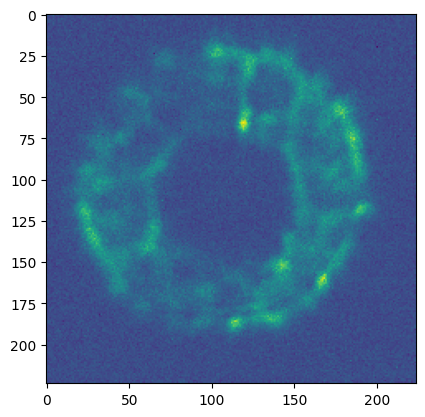

162.93333333333334 160.0 16.58272193177787 114.75951564277824 106.10903020588503 186.0


In [6]:
fig = plt.figure()
im, mean, median, stddev, x, y, width = process_fass_image(d['data'][2500, :, :])
plt.imshow(im)
plt.show()
print(mean, median, stddev, x, y, width)

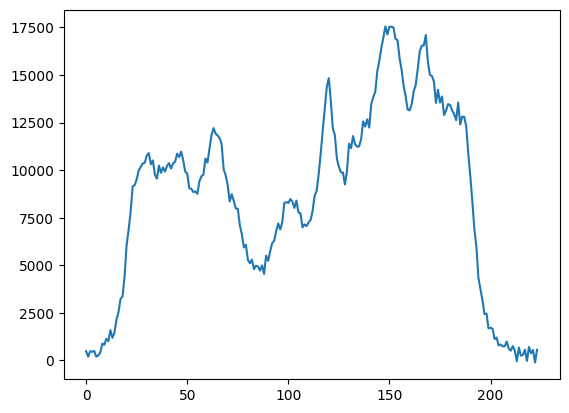

In [7]:
fig = plt.Figure()
plt.plot(im.sum(axis=0))
plt.show()

In [8]:
d['frame_times'][0:3]

<Time object: scale='utc' format='iso' value=['2022-11-07 03:43:13.912' '2022-11-07 03:43:13.914'
 '2022-11-07 03:43:13.916']>

In [9]:
i1 = 410
i2 = 411
image1 = d['data'][i1, :, :]
image2 = d['data'][i2, :, :]
warped1 = warp_polar(image1, center=(109,109), radius=100, output_shape=(int(2 * np.pi * 200),200), scaling='linear', preserve_range=True)
warped2 = warp_polar(image2, center=(109,109), radius=100, output_shape=(int(2 * np.pi * 200),200), scaling='linear', preserve_range=True)
diff = warped1 - warped2

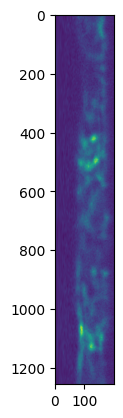

In [10]:
fig = plt.figure()
plt.imshow(warped1)
plt.show()

In [11]:
coadd = d['data'][0:1000, :, :].sum(axis=0)
warped_coadd = warp_polar(coadd, (109,109), radius=100, output_shape=(200,200), scaling='linear', preserve_range=True)

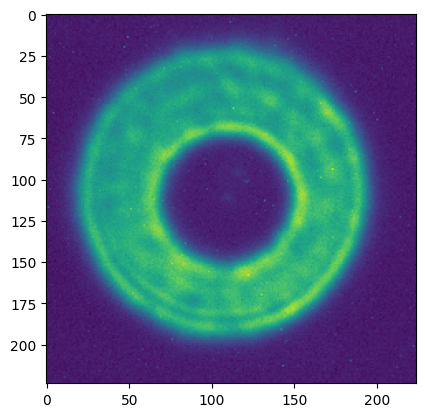

In [12]:
fig = plt.figure()
plt.imshow(coadd)
plt.show()

In [13]:
del uc

NameError: name 'uc' is not defined

In [14]:
uc = unwrap_fass_cube(d['data'], nproc=8)

In [15]:
uc.size / 1024**3

1.1500474764034152

2


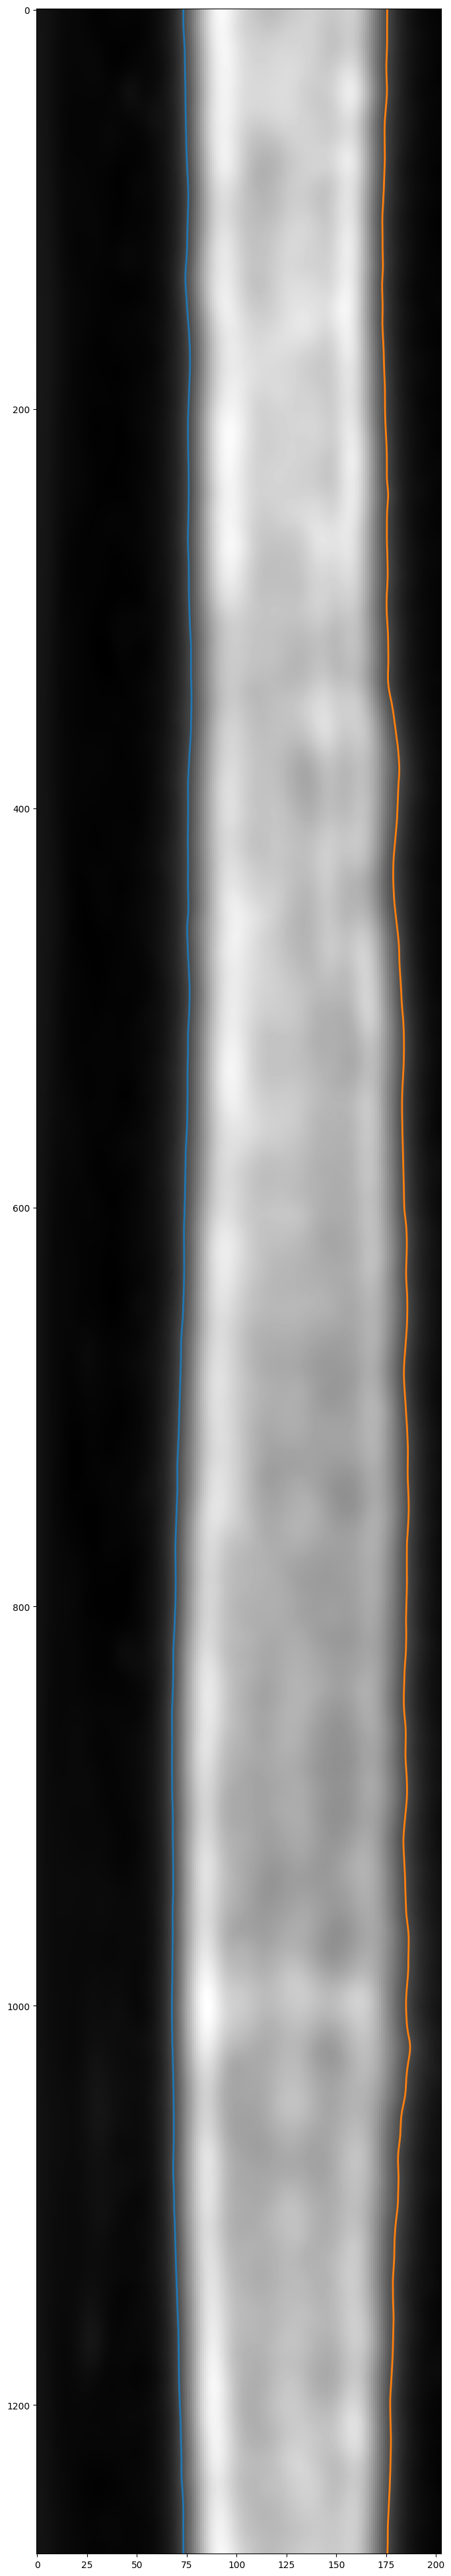

In [16]:
fig = plt.figure(figsize=(50, 50))
stacked = uc.mean(axis=0)
stacked = filters.gaussian(stacked, sigma=4)
plt.imshow(stacked, cmap='gray')
contours = measure.find_contours(stacked, 0.3 * stacked.max())
print(len(contours))
for contour in contours:
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2)
plt.show()

In [17]:
pup_inner = np.mean(contours[0][:, 1]) # * np.ones(stacked.shape[0])
pup_outer = np.mean(contours[1][:, 1]) # * np.ones(stacked.shape[0])


In [18]:
fitter = fitting.LinearLSQFitter()
contour_model = models.Legendre1D(degree=5)
contour_inner = fitter(contour_model, contours[0][:, 0], contours[0][:, 1])
contour_outer = fitter(contour_model, contours[1][:, 0], contours[1][:, 1])

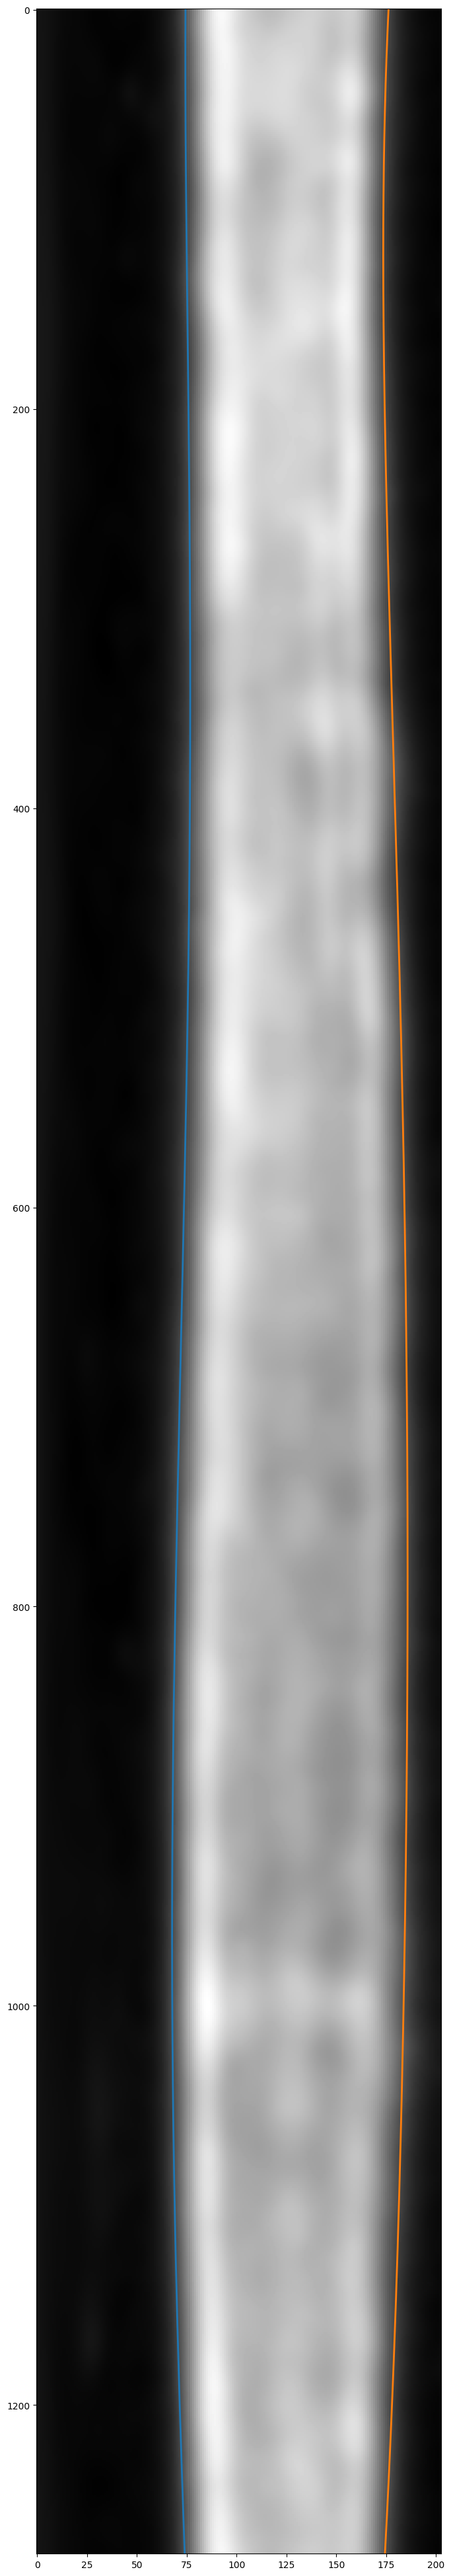

In [19]:
fig = plt.figure(figsize=(50, 50))
stacked = uc.mean(axis=0)
stacked = filters.gaussian(stacked, sigma=4)
y = np.arange(stacked.shape[0])
plt.imshow(stacked, cmap='gray')
contours = measure.find_contours(stacked, 0.3 * stacked.max())
plt.plot(contour_inner(y), y, linewidth=2)
plt.plot(contour_outer(y), y, linewidth=2)
plt.show()

In [20]:
src_inner = np.array([pup_inner * np.ones(stacked.shape[0]), y]).T
src_outer = np.array([pup_outer * np.ones(stacked.shape[0]), y]).T
src = np.vstack([src_inner, src_outer])
src

array([[7.25719735e+01, 0.00000000e+00],
       [7.25719735e+01, 1.00000000e+00],
       [7.25719735e+01, 2.00000000e+00],
       ...,
       [1.80496561e+02, 1.27200000e+03],
       [1.80496561e+02, 1.27300000e+03],
       [1.80496561e+02, 1.27400000e+03]])

In [21]:
dst_inner = np.array([contour_inner(y), y]).T
dst_outer = np.array([contour_outer(y), y]).T
dst = np.vstack([dst_inner, dst_outer])
dst

array([[7.43820849e+01, 0.00000000e+00],
       [7.43768987e+01, 1.00000000e+00],
       [7.43719532e+01, 2.00000000e+00],
       ...,
       [1.74520903e+02, 1.27200000e+03],
       [1.74467104e+02, 1.27300000e+03],
       [1.74413109e+02, 1.27400000e+03]])

In [22]:
tform = PiecewiseAffineTransform()
tform.estimate(src, dst)

True

In [24]:
rectified, flat_image = rectify_fass_cube(uc)

In [25]:
rstacked = rectified.mean(axis=0)

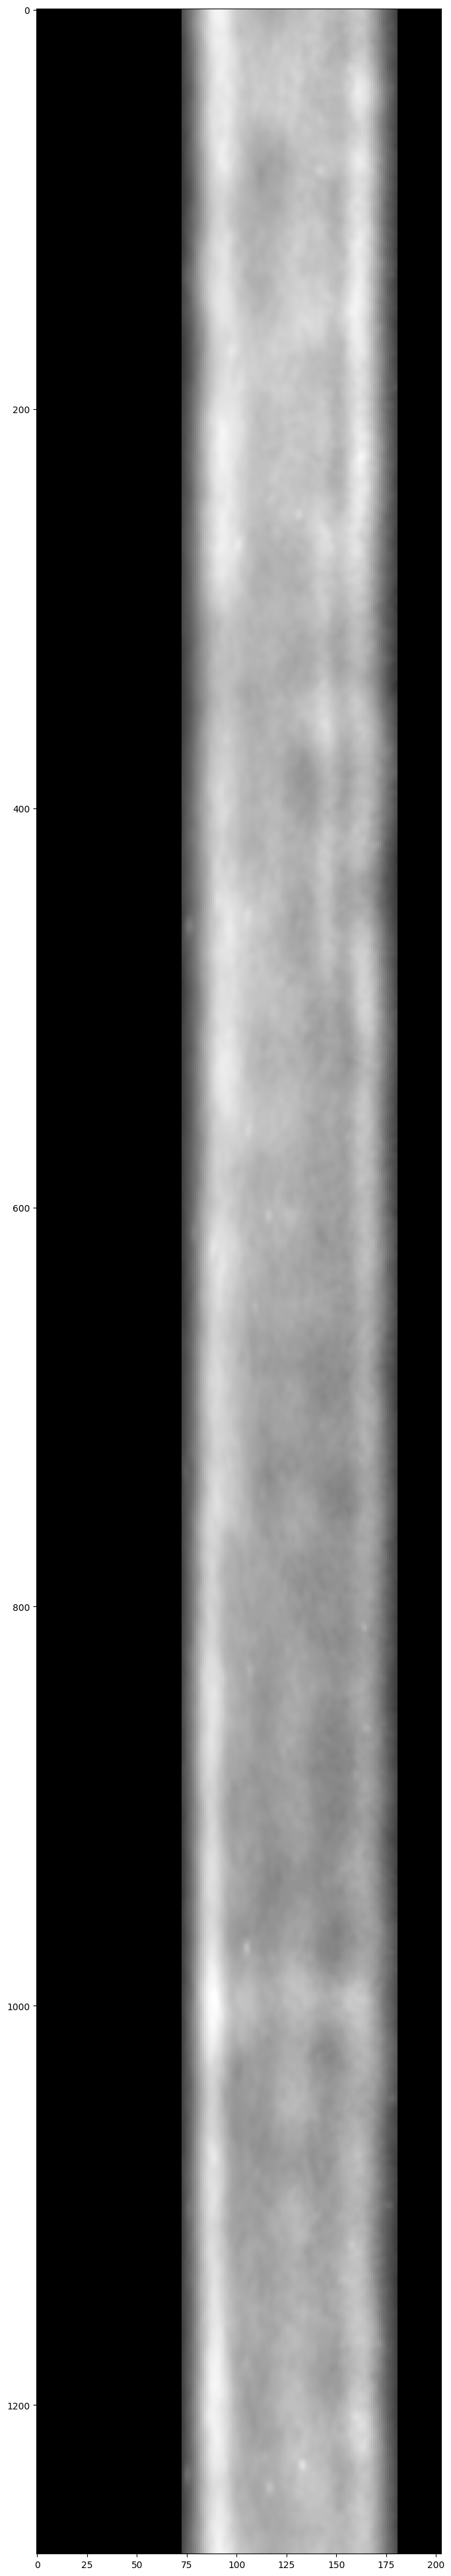

In [26]:
fig = plt.figure(figsize=(50, 50))
plt.imshow(rstacked, cmap='gray')
plt.show()

In [40]:
flat_image[flat_image == 0] = np.nan
flatcube = rectified / flat_image

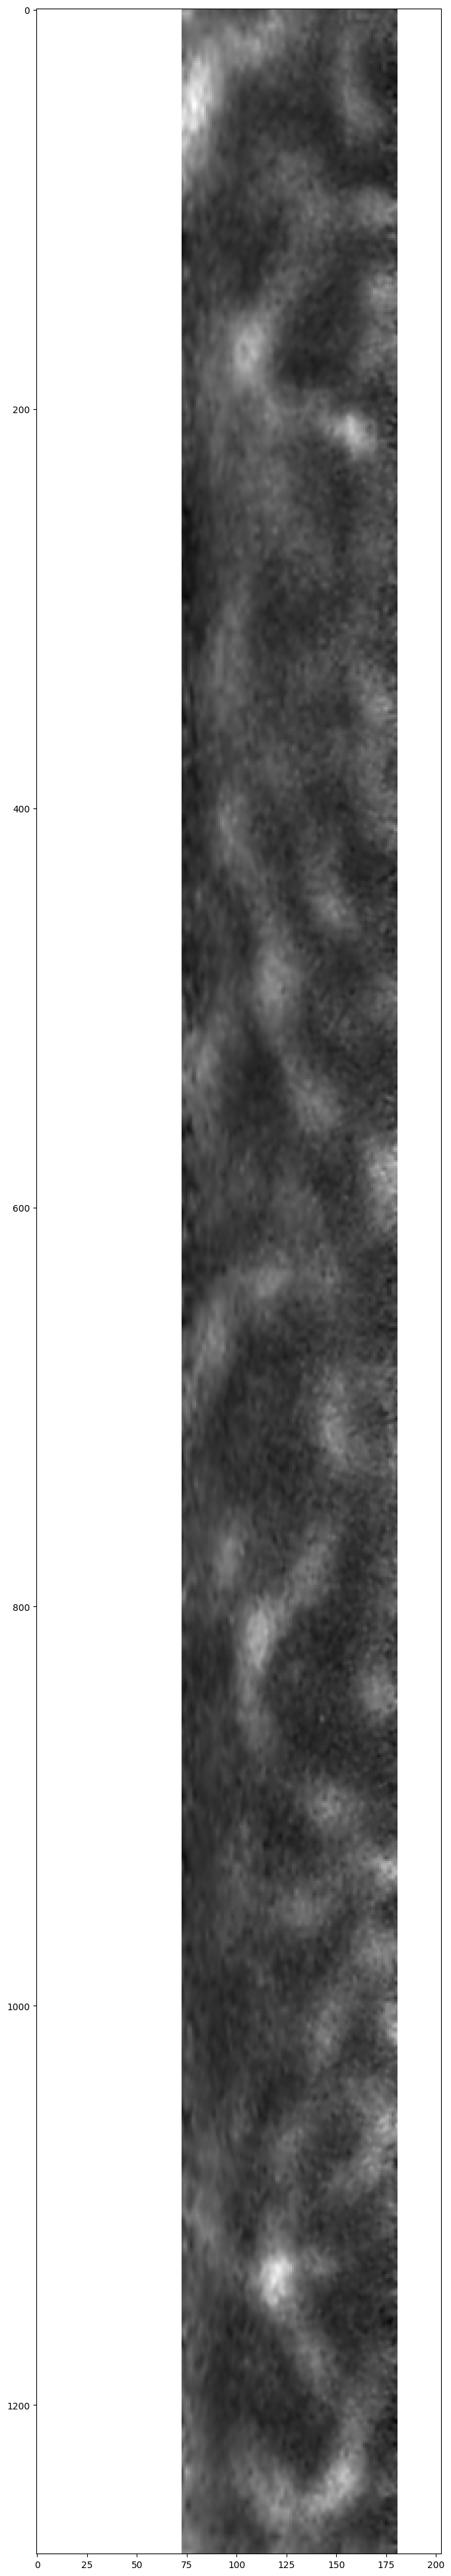

In [43]:
fig = plt.figure(figsize=(50, 50))
plt.imshow(flatcube[2, :, :], cmap='gray')
plt.show()

In [39]:
flatcube.shape

(1275, 203)